<br/>

$$ \huge{\underline{\textbf{ Feature Construction for Linear Models }}} $$

<br/>

We are going to use [Gradient MC](0903a_Gradient_MC.ipynb) as a learning algorithm. This is the "fixed" version.

In [306]:
def gradient_MC(env, policy, ep, gamma, model, callback=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
    """    
    for it in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
        
        if callback is not None:
            callback(ee)

In [11]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

</br>

<center> **Polynomial Basis** </center>


<img src="assets/0905_Poly_Basis.png"/>
<center>Polynomial Basis - from Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.5.1</center>

In [ ]:
class PolynomialFunctionApproximator():
    """Very simple function approximator"""
    def __init__(self, learn_rate, nb_groups, group_size):
        self._lr = learn_rate
        self._group_size = group_size
        self._w = np.zeros(nb_groups)  # weights
        
    def evaluate(self, state):
        group = (state-1) // self._group_size
        return self._w[group]
    
    def train(self, state, target):        
        # Because grad_v_hat is a one-hot vector, we can optimize:
        group = (state-1) // self._group_size
        self._w[group] += self._lr * (target - self._w[group])  # standard MC update!
        
        # Original impl., for reference:
        # w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)

<br/>

<center>**Fourier Basis**</center>

<img src="assets/0905_Fourier_Basis.png"/>
<center>Fourier Basis - both from Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.5.2 </center>

In [1]:
class PolynomialFunctionApproximator():
    """Very simple function approximator"""
    def __init__(self, learn_rate, nb_groups, group_size):
        self._lr = learn_rate
        self._group_size = group_size
        self._w = np.zeros(nb_groups)  # weights
        
    def evaluate(self, state):
        group = (state-1) // self._group_size
        return self._w[group]
    
    def train(self, state, target):        
        # Because grad_v_hat is a one-hot vector, we can optimize:
        group = (state-1) // self._group_size
        self._w[group] += self._lr * (target - self._w[group])  # standard MC update!
        
        # Original impl., for reference:
        # w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 9.2 (left) - "True" value is approximated with stright line<center/></td>
    </tr>
</table>

# Experiment Setup

In [287]:
import numpy as np
import matplotlib.pyplot as plt

In [288]:
class FunctionApproximator():
    """Very simple function approximator"""
    def __init__(self, learn_rate, nb_groups, group_size):
        self._lr = learn_rate
        self._group_size = group_size
        self._w = np.zeros(nb_groups)  # weights
        
    def evaluate(self, state):
        group = (state-1) // self._group_size
        return self._w[group]
    
    def train(self, state, target):        
        # Because grad_v_hat is a one-hot vector, we can optimize:
        group = (state-1) // self._group_size
        self._w[group] += self._lr * (target - self._w[group])  # standard MC update!
        
        # Original impl., for reference:
        # w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)

In [289]:
class LinearEnv:
    """
    State nb:   [   0       1   ...   499   500   501   ...   1000    1001  ]
    State type: [terminal   .   ...    .   start   .    ...     .   terminal]
    """
    V_approx = np.arange(-1001, 1001, 2) / 1000.0  # ignore nonlinearity at terminal states
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self._state = 500
        self._done = False
        return self._state
        
    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
    
        if action == 0:   self._state -= np.random.randint(1, 101)  # step left
        elif action == 1: self._state += np.random.randint(1, 101)  # step right
        else: raise ValueError('Invalid action')
            
        self._state = np.clip(self._state, 0, 1001)  # clip to 0..1001
        if self._state in [0, 1001]:                 # both 0 and 1001 are terminal
            self._done = True
        
        if self._state == 0:
            return self._state, -1, self._done       # state, rew, done
        elif self._state == 1001:
            return self._state, 1, self._done
        else:
            return self._state, 0, self._done

In [290]:
def plot_linear(V, env, freq=None, saveimg=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Note, state 0 is terminal, so we exclude it
    ax.plot(range(1,1001), env.V_approx[1:], color='red', linewidth=0.8, label='"True" value')
    ax.plot(range(1,1001), V[1:], color='blue', linewidth=0.8, label='Approx. MC value')
    ax.set_xlabel('State')
    ax.set_ylabel('Value Scale')
    ax.legend()
    
    if freq is not None:
        mu = np.zeros(len(V))       # convert to array, V has same len as freq
        for st in range(len(V)):
            mu[st] = freq[st]
        ax2 = ax.twinx()
        # again, exclude terminal state 0
        ax2.bar(range(1,1001), mu[1:], color='gray', width=5, label='State Distr.')
        ax2.set_ylabel('Distribution Scale')
        ax2.legend(loc='right', bbox_to_anchor=(1.0, 0.2))
    
    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()   

In [291]:
env = LinearEnv()

In [292]:
def policy(st):
    return np.random.choice([0, 1])

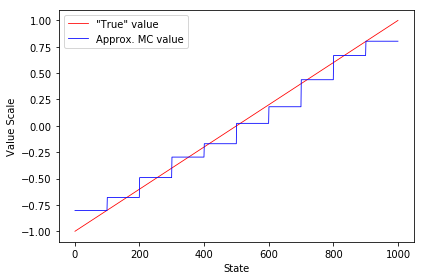

In [293]:
model = FunctionApproximator(learn_rate=0.0003, nb_groups=10, group_size=100)
gradient_MC(env, policy, ep=5000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

In [309]:
class PolynomialFuncApprox():
    """Polynomial function approximator"""
    def __init__(self, learn_rate, order, nb_states):
        self._lr = learn_rate
        self._order = order
        self._nb_states = nb_states
        self._w = np.zeros(order+1)
        
        self._bases = []
        for n in range(order+1):
            self._bases.append(lambda st, n=n: pow(st, n))
        
    def evaluate(self, state):
        st01 = state / self._nb_states                 # map to 0..1
        x = np.power(st01, range(self._order+1))       # x = [st**0, st**1, ..., st**order]
                
        return x @ self._w                             # linear combination, i.e. dot product
        
        #feature = np.asarray([func(st01) for func in self._bases])
        #return np.dot(self._w, feature)

    def train(self, state, target):
        st01 = state / self._nb_states                 # map to 0..1
        grad = np.power(st01, range(self._order+1))    # grad. of lin. comb. is input x
        
        v_hat = self.evaluate(state)
        self._w += self._lr * (target - v_hat) * grad  # Gradient MC update, see chapt. 9.3
                
        # Original impl., for reference (chapt. 9.1):
        # w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)

0
100
200
300
400
500
600
700
800
900


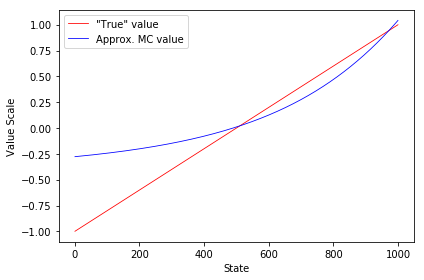

In [310]:
rmse = []

def callback(e):
    V = np.array([model.evaluate(st) for st in range(1001)])
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))
    rmse.append(err)
    
    if e % 100 == 0:
        print(e)

model = PolynomialFuncApprox(learn_rate=0.0001, order=5, nb_states=1000)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model, callback=callback)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

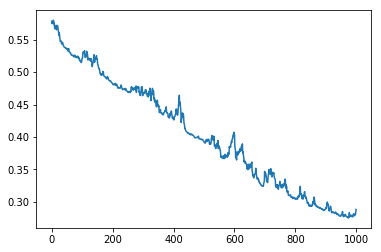

In [311]:
plt.plot(rmse)

In [298]:
np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))

0.26347383987829004

In [297]:
np.sqrt(np.mean(np.power(env.V_approx - np.array(V), 2)))

0.26418046765102315

In [273]:
env.V_approx[:5]

array([-1.001, -0.999, -0.997, -0.995, -0.993])

In [277]:
V[:5]

array([-0.60401071, -0.60327031, -0.60252908, -0.60178703, -0.60104415])

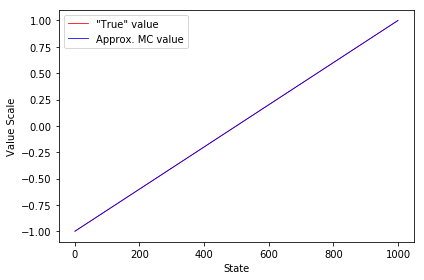

In [65]:
model._w = np.array([-1, 2, 0, 0, 0, 0])
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

# = = = = = = 

In [249]:
def figure_9_5(true_value):
    # my machine can only afford 1 run
    runs = 1

    episodes = 100

    # # of bases
    orders = [5]

    alphas = [1e-4, 5e-5]
    labels = [['polynomial basis'] * 3, ['fourier basis'] * 3]

    # track errors for each episode
    errors = np.zeros((len(alphas), len(orders), episodes))
    for run in range(runs):
        for i in range(len(orders)):
            value_functions = [BasesValueFunction(orders[i], POLYNOMIAL_BASES), BasesValueFunction(orders[i], FOURIER_BASES)]
            for j in range(len(value_functions)):
                for episode in range(episodes):

                    # gradient Monte Carlo algorithm
                    gradient_monte_carlo(value_functions[j], alphas[j])

                    # get state values under current value function
                    state_values = [value_functions[j].value(state) for state in STATES]

                    # get the root-mean-squared error
                    errors[j, i, episode] += np.sqrt(np.mean(np.power(true_value[1: -1] - state_values, 2)))

                return state_values  # <--
                    
    # average over independent runs
    errors /= runs

    for i in range(len(alphas)):
        for j in range(len(orders)):
            plt.plot(errors[i, j, :], label='%s order = %d' % (labels[i][j], orders[j]))
    plt.xlabel('Episodes')
    plt.ylabel('RMSVE')
    plt.legend()

    plt.show()

In [225]:
true_value = compute_true_value()

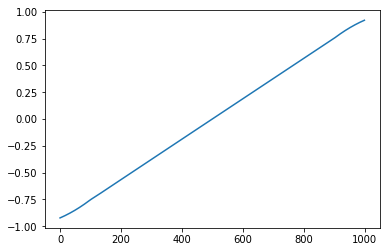

In [227]:
plt.plot(true_value[1:-1])

In [246]:
env.V_approx.shape
env_sh = np.array([*env.V_approx, 0])
env_sh.shape

(1002,)

In [250]:
state_values = figure_9_5(env_sh)

In [263]:
np.array(V).shape

(1001,)

In [267]:
np.sqrt(np.mean(np.power(true_value[1: ] - np.array(V), 2)))

0.1342640612026904

In [280]:
np.sqrt(np.mean(np.power(env.V_approx - np.array(V), 2)))

0.1539685747097708

In [272]:
env.V_approx[0]

-1.001

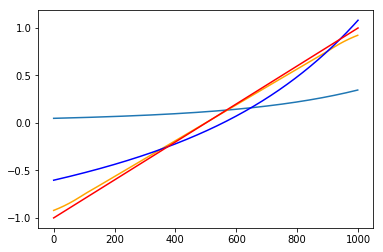

In [270]:
plt.plot(state_values)
plt.plot(true_value[1:-1], color='orange')
plt.plot(V, color='blue')
plt.plot(env.V_approx, color='red')

In [ ]:
np.sqrt(np.mean(np.power(true_value[1: -1] - state_values, 2)))

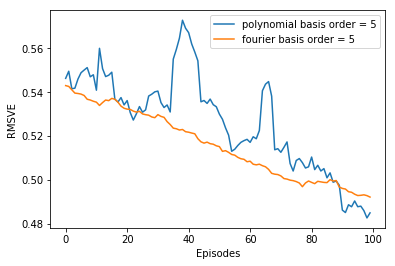

In [241]:
figure_9_5(true_value)

In [223]:
# # of states except for terminal states
N_STATES = 1000

# all states
STATES = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100

In [224]:
def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)
                    # asynchronous update for faster convergence
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value

In [231]:
# a wrapper class for polynomial / Fourier -based value function
POLYNOMIAL_BASES = 0
FOURIER_BASES = 1
class BasesValueFunction:
    # @order: # of bases, each function also has one more constant parameter (called bias in machine learning)
    # @type: polynomial bases or Fourier bases
    def __init__(self, order, type):
        self.order = order
        self.weights = np.zeros(order + 1)

        # set up bases function
        self.bases = []
        if type == POLYNOMIAL_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: pow(s, i))
        elif type == FOURIER_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: np.cos(i * np.pi * s))

    # get the value of @state
    def value(self, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get the feature vector
        feature = np.asarray([func(state) for func in self.bases])
        return np.dot(self.weights, feature)

    def update(self, delta, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get derivative value
        derivative_value = np.asarray([func(state) for func in self.bases])
        self.weights += delta * derivative_value

In [236]:
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = [state]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)
        trajectory.append(next_state)
        state = next_state

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:
        delta = alpha * (reward - value_function.value(state))
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1

In [238]:
def get_action():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

In [240]:
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

In [ ]:
true_value = compute_true_value()